<a href="https://colab.research.google.com/github/AkshayJS/CS6400-Thesis-on-COVID-19-detection-based-on-Chest-X-ray-images/blob/main/QaTa_COV19_ChestXray_Identification_Unet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Introduction



<!--![qata](https://181fde73e78a.ngrok.io/static/imgs/banner.png)-->
![qata](https://c1df151ac00c.ngrok.io/static/imgs/banner.png)

In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-xs5oyrpp
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-xs5oyrpp
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=98951 sha256=7144ebfd50ab1fbee38e4311ca6837bf08592faa4883581e6535b01e06068b47
  Stored in directory: /tmp/pip-ephem-wheel-cache-7uyzmb7_/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-nlduacb3
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-nlduacb3
     |████████████████████████████████| 58 kB 4.4 MB/s 
     |█████████

## 1. Importing the dataset

Importing dataset



*   The dataset is taken from Kaggle repository **[QaTa-COV19](https://www.kaggle.com/aysendegerli/qatacov19-dataset)** 
*   Setting up the dataset involves following steps:


1.   Mount the google drive with Google authorization
2.   Navigate to **[Kaggle](https://www.kaggle.com)**. Then go to the Account tab of your user profile and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials
3. Upload the downloaded json having credentials.
4. Download dataset from kaggle

In [2]:
import os
from google.colab import drive

# Mount the google drive
drive.mount('/content/gdrive')

# Setting the environment path
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

!kaggle datasets download -d aysendegerli/qatacov19-dataset

Mounted at /content/gdrive
100% 4.79G/4.79G [01:38<00:00, 56.0MB/s]
100% 4.79G/4.79G [01:38<00:00, 52.1MB/s]


In [3]:
#unzipping the zip files and deleting the zip files
!unzip -q \*.zip  && rm *.zip

## 2. EDA

No. of chest images =  4603
No. of ground truth images =  2951
Size of chest truth Image:(741,748)
Size of Ground truth Image:(224,224)


<BarContainer object of 2 artists>

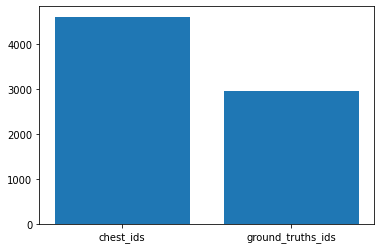

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

path_chestXrayImages = "/content/QaTa-COV19/QaTa-COV19/Images"
path_groundTruthImages = "/content/QaTa-COV19/QaTa-COV19/Ground-truths"

chest_ids = next(os.walk(path_chestXrayImages))[2] # list of names all images in the given path
print("No. of chest images = ", len(chest_ids))

ground_truths_ids = next(os.walk(path_groundTruthImages))[2] # list of names all images in the given path
print("No. of ground truth images = ", len(ground_truths_ids))

im = Image.open(os.path.join(path_chestXrayImages,chest_ids[0]))
width, height = im.size
print("Size of chest truth Image:({},{})".format(width,height))

im = Image.open(os.path.join(path_groundTruthImages,ground_truths_ids[0]))
width, height = im.size
print("Size of Ground truth Image:({},{})".format(width,height))

plt.bar(['chest_ids','ground_truths_ids'],[len(chest_ids),len(ground_truths_ids)])

In [5]:
# Splitting the data to training to train and test data
from sklearn.model_selection import train_test_split
train_id, valid_id = train_test_split(ground_truths_ids, test_size=0.2, random_state=42)
print(f'Dimensions of X_train: {len(train_id)}')
print(f'Dimensions of X_valid: {len(valid_id)}')

Dimensions of X_train: 2360
Dimensions of X_valid: 591


In [6]:
counter = 0
for ids in ground_truths_ids:
  if Image.open(os.path.join(path_chestXrayImages,ids[5:])).size == Image.open(os.path.join(path_groundTruthImages,ids)).size == (224,224):
    counter+=1
print(f'Images Scanned: {counter}')

Images Scanned: 2951


In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [10]:

# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap = 'seismic', interpolation = 'bilinear')
    plt.show()

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """COVID Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        image_ids (str) : ids for the each COVID images
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self,
            image_ids, 
            images_dir, 
            masks_dir,
            augmentation=None, 
            preprocessing=None,
    ):
        #self.ids = os.listdir(masks_dir)
        #self.images_fps = [os.path.join(images_dir, image_id[5:]) for image_id in self.ids]
        #self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.ids = image_ids
        self.images_fps = [os.path.join(images_dir, image_id[5:]) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
      
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)/255.
        masks = [(mask == v) for v in [1]]
        mask = np.stack(masks, axis=-1).astype('float')

        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

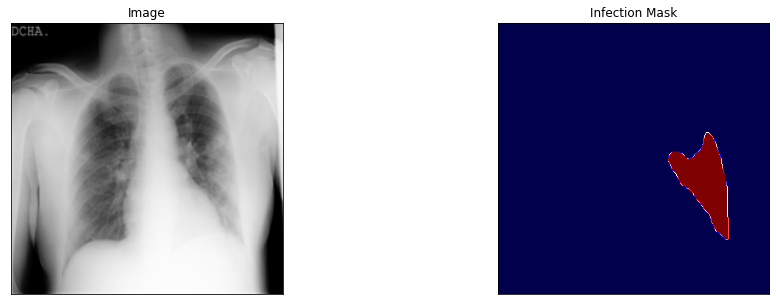

In [ ]:
# Lets look at data we have

dataset = Dataset(train_id,path_chestXrayImages, path_groundTruthImages)

image, mask = dataset[1714] # get some sample
visualize(
    image=image, 
    infection_mask=mask.squeeze(),
)

In [ ]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
        albu.RandomCrop(height=224, width=224, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(224, 224)
        #albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
  
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

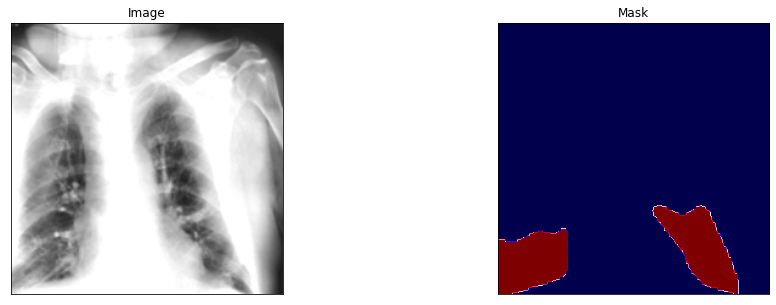

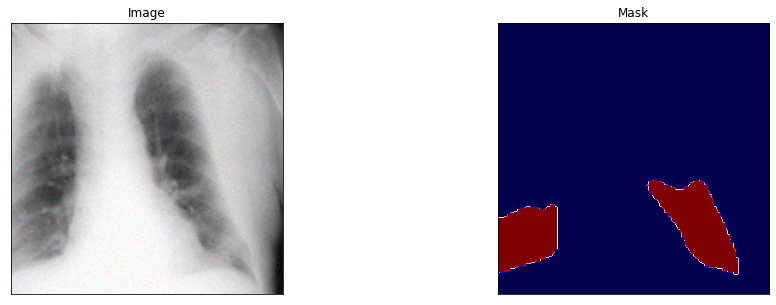

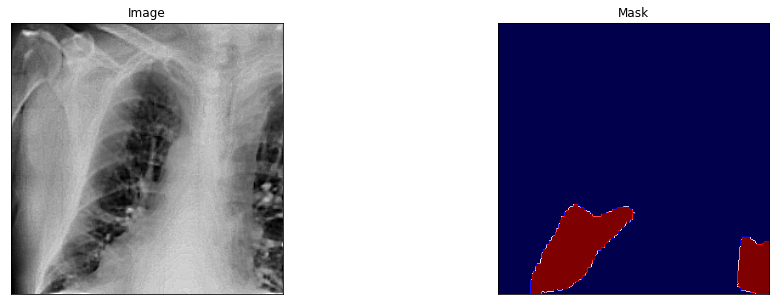

In [ ]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    train_id,path_chestXrayImages, path_groundTruthImages, 
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[6]
    visualize(image=image, mask=mask.squeeze())

Model creation

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
'''model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
     
    activation=ACTIVATION,
)'''
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


In [ ]:
train_dataset = Dataset(
    train_id,path_chestXrayImages, path_groundTruthImages,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    valid_id,path_chestXrayImages, path_groundTruthImages,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/295 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/591 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 591/591 [00:14<00:00, 40.43it/s, dice_loss - 0.3576, iou_score - 0.5216]
Model saved!

Epoch: 1
valid: 100%|██████████| 591/591 [00:14<00:00, 39.77it/s, dice_loss - 0.3202, iou_score - 0.5684]
Model saved!

Epoch: 2
valid:  75%|███████▍  | 443/591 [00:11<00:03, 41.18it/s, dice_loss - 0.2791, iou_score - 0.6082]